# Joint-NTFによる特許分析

**Input:**
- "construction_patent_2001-2021.xlsx"　-　2001年から2021年までの建設会社の特許リスト

**Output:**
- 例："株式会社熊谷組-五洋建設株式会社_発明の名称-要約-詳細な説明_c10_d10_α100_β100000_min5_max1000_YS.xlsx"　-　熊谷組と五洋建設の特許比較結果

**処理：**
- 準備
- Inputファイル固有の前処理
- 文書のテンソル化
- 最適化実行
- Outputファイルの出力・グラフの可視化


##  準備
ライブラリをインポート，特許データのエクセルの読み込み、変数初期化

In [1]:
# 標準ライブラリ
import sys
from sys import float_info
import os
from datetime import datetime as dt
import re
import itertools
import collections


# データ分析系
import numpy as np
import cupy as cp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 文字列処理系
import MeCab
import ipadic
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

# 出力系
import openpyxl
from openpyxl.drawing.image import Image

# 予測系
import pmdarima as pm

# 自作関数
sys.path.append('../func_definitions/')
import tensorizer, optimize_funcs, normalize_funcs, output_funcs


In [3]:
# 特許データ読み込み
df_org = pd.read_excel('../input_files/construction_patent_2001-2021.xlsx',header=0,engine='openpyxl')
df_org.head(1)

,公開・公表番号,発明の名称,公開・公表日,出願日,原出願日,出願人・権利者名,出願番号,登録番号,筆頭発明者,発明者名,IPC,筆頭ＩＰＣ,Ｆターム,FI,ステイタス,ST,早期請求出願有無,要約,全請求項,詳細な説明
0,登実第3082540号,Ｚ形仕切付段ボール箱,2001.12.14,2001-06-08,NaT,佐藤工業株式会社,実願2001-003729,登実第3082540号,佐藤 浩康,佐藤 浩康,B65D 5/491 (2006.01),B65D 5/491 (2006.01),"3E060AA03,3E060AB05,3E060BC02,3E060CB04,3E060C...","B65D 5/48 101J,B65D 5/498",存続期間満了による抹消,×,無,【要約】【課題】 強度が劣る原紙を用いたとしても箱の強度が維持される外装用段ボール箱を得んと...,【実用新案登録請求の範囲】【請求項１】 広幅と狭幅の各一対の側板を交互に横方向に連設し、それ...,【考案の詳細な説明】 【０００１】 【考案の属する技術分野】 本考案は、袋菓子または詰...


In [4]:
# 変数初期化

# 最小値
eps = float_info.min

# 対象とする特許の情報
domain1 = '株式会社熊谷組'  # 比較対象1の組織名
domain2 = '五洋建設株式会社'  # 比較対象2の組織名
sentence_column_list = ['発明の名称','要約','詳細な説明']  #トピック抽出の対象にする列名のリスト


# 単語-文書-時間テンソル作成時の情報
excepword = ["修正","部","第","各","請求","特許","本","一定","同上","参照","発明","広報","実施","特開","背景","特","前記","図","要約","方法","手段","対象","現場","評価" ,"可能","構成","当該","以下","以上","該当","項","前記","複数","上記"]  #除外する特定の名詞
exceptype= ["接尾","副詞可能","数詞","助数詞","代名詞","複数"] #除外する名詞の種類
min_df = 5  # 対象にする単語の文書頻度(document frequency)の最小値
max_df = 1000  # 対象にする単語の文書頻度(document frequency)の最大値
time_span= "YS"  # "YS"-年単位 or "QS"-四半期単位 or "MS"-月単位


# 最適化時のパラメータ
c = 10  # 抽出する共通トピック数
d = 10  # 抽出する非共通トピック数
K = c+d  
alpha = 100  # 共通成分をより厳しく抽出するハイパラ
beta = 100000  # 非共通成分をより厳しく抽出するハイパラ


# 出力エクセルファイルパス
output_excel_file_path = "../output_files/{0}-{1}_{2}_c{3}_d{4}_α{5}_β{6}_min{7}_max{8}_{9}.xlsx".format(domain1, domain2,  "-".join(sentence_column_list),c,d,alpha,beta,min_df,max_df,time_span)

## Inputファイル固有の前処理
二つのドメインのデータフレームを作成


In [5]:
df=df_org.copy()

df["number"] = df.index
df['datetime'] = [dt.strptime(i.split(',')[0],  '%Y.%m.%d') for i in df['公開・公表日']]  #公開・公表日を datetime64[ns] 型（ Timestamp 型）に 、複数あるのは先頭のだけに
df.set_index('datetime', inplace=True)
df["domain"] = [set(i.split(",")) for i in df['出願人・権利者名']]    #出願名をスプリットしてset型に
df['sentence'] = ""
for column in sentence_column_list:
    df[column] = df[column].fillna("")
    df['sentence'] += df[column].astype("str")
 
df1 = df[df["domain"].apply(lambda x: domain1 in x)]
df2 = df[df["domain"].apply(lambda x: domain2 in x)]

df1 = df1.rename(columns={'公開・公表番号': 'id_a'})
df2 = df2.rename(columns={'公開・公表番号': 'id_b'})

print(df1.shape)
print(df2.shape)

(1650, 23)
(1277, 23)


## 文書のテンソル化
二つのドメインのデータフレームから、それぞれ時間ー単語ー文書テンソルを作成

In [6]:
import importlib
importlib.reload(optimize_funcs)

<module 'optimize_funcs' from '/Joint-NTF/NTF_algorithm/jupyter_workspace/../func_definitions/optimize_funcs.py'>

In [7]:
my_tensorizer = tensorizer.DocumentJntfTensorizer(df1, df2, exceptype, excepword,max_df, min_df,time_span)
tensors = my_tensorizer.tensorize()
print(tensors.X1.shape)
print(tensors.X2.shape)

/opt/conda/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


(21, 6312, 1650)
(21, 6312, 1277)


## 最適化実行

In [ ]:
U, V ,W, memo = optimize_funcs.optimize_doc_joint_NTF(tensors,Kc=c, Kd=d,alpha=alpha, beta=beta, iter_num=100)  #NTF実行

## Outputファイルの出力・グラフの可視化

In [ ]:
## エクセル出力
head_num = min(len(terms), 30) #エクセルに上位何単語まで出力するか

terms_df = output_funcs.make_terms_df(terms,df1,df2,my_tensorizer)

topic_weight_df1 = output_funcs.make_topic_weight_df(U[0],K,terms,head_num)
topic_weight_df2 = output_funcs.make_topic_weight_df(U[1],K,terms,head_num)

document_weight_df1 = output_funcs.make_document_weight_df(V[0],W[0],X1,K,df1,time_to_doc1)
document_weight_df2 = output_funcs.make_document_weight_df(V[1],W[1],X2,K,df2,time_to_doc2)

with pd.ExcelWriter(output_excel_file_path) as writer:
    terms_df.to_excel(writer, sheet_name='terms')
    topic_weight_df1.to_excel(writer, sheet_name=domain1+'_topic1')
    topic_weight_df2.to_excel(writer, sheet_name=domain2+'_topic2')
    document_weight_df1.to_excel(writer, sheet_name=domain1+'_topic_doc')
    document_weight_df2.to_excel(writer, sheet_name=domain2+'_topic_doc')


        


datetime
2001-10-19       24
2001-12-14       26
2001-08-10       34
2001-09-04       47
2001-05-29       48
              ...  
2021-02-18    44352
2021-02-12    44431
2021-02-12    44433
2021-01-07    44540
2021-01-07    44541
Name: number, Length: 2927, dtype: int64


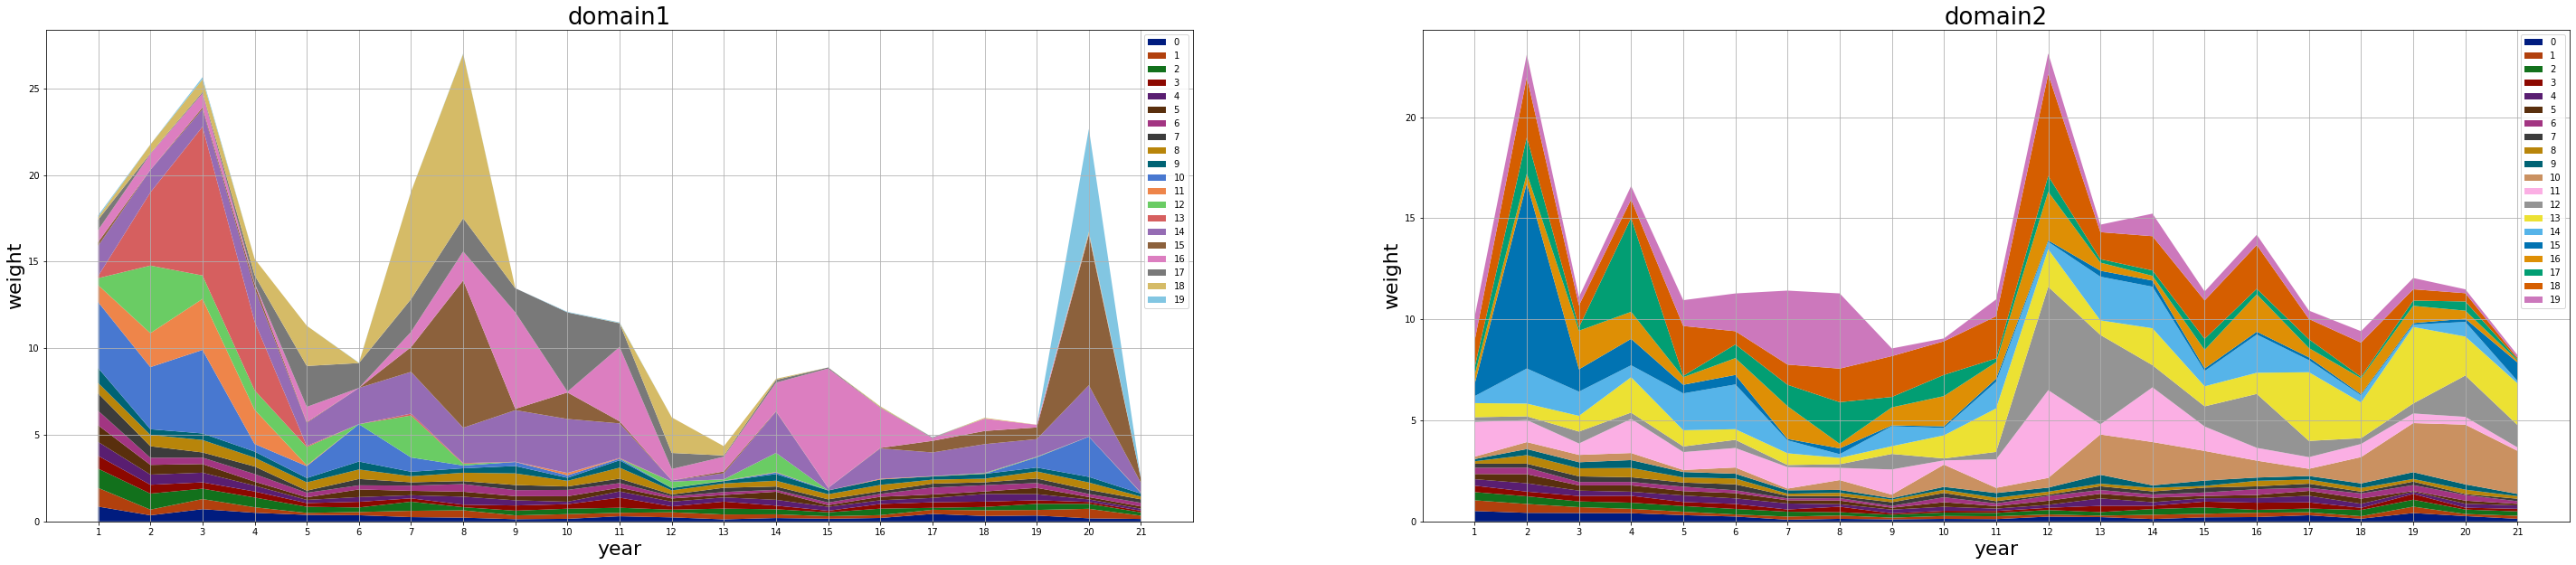

In [ ]:
# グラフの可視化・グラフをエクセルに追加
fig = output_funcs.make_comparison_graph(X1,V,W,c,d,time_to_doc1,time_to_doc2)
plt.show()
fig.savefig("img_tmp.png")


#画像挿入するエクセルファイルを指定
wb = openpyxl.load_workbook(output_excel_file_path)
wb.create_sheet("graph")
ws = wb["graph"]
img = Image("img_tmp.png")
ws.add_image(img, 'A1')
wb.save(output_excel_file_path)
os.remove("img_tmp.png")


